In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import tensorflow as tf
import time
import scipy.misc
import matplotlib as mp
import matplotlib.pyplot as plt
import itertools
import cPickle
import collections
import Image, ImageDraw
import PIL
from PIL import ImageFont
import os
import glob
%matplotlib inline

In [2]:
def batch_norm(x, n_out, phase_train, convolutional = False, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        if convolutional:
            batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        
        else:
            batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
        
        ema = tf.train.ExponentialMovingAverage(decay=0.999)
        
        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

In [3]:
def cifar10_concatenate():
    
    img = np.zeros([50000,3072])
    lbl = np.zeros([50000])
    for i in range(5):
        with open('/home/skyolia/TF_Project/Cifar10/cifar-10-batches-py/data_batch_'+str(i+1),'rb') as f:
            data = cPickle.load(f)
        for j in range(10000):
            img[j+10000*i] = data['data'][j]
            lbl[j+10000*i] = data['labels'][j]
        
        #print(lbl)
        #print("//////////////////////////////////////////////")
        
    return img, lbl

In [4]:
with open('/home/skyolia/TF_Project/Cifar10/cifar-10-batches-py/test_batch','rb') as f:
    data2 = cPickle.load(f)
    test_labels = np.asarray(data2['labels'])
    test_data = np.asarray(data2['data'])
    

In [5]:
train_data, train_labels = cifar10_concatenate()
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [6]:
def cifar10_reshape(data):
    
    size = data.shape[0]
    img = np.zeros([size,3072])
    
    for i in range(size):
        imageToUse = data[i]
        
        image = imageToUse.reshape(3,32,32).transpose(1,2,0)
        elmn = image.flatten()
        
        img[i] = elmn
        
    return img
    

In [7]:
def normalisation(array):
    
    array = array.astype('float32')
    array_nomalized = array / 255.0       
    return array_nomalized
        

In [8]:
def cifar10_preparation():
    
    train_reshape = cifar10_reshape(train_data)
    test_reshape = cifar10_reshape(test_data)
    print("reshape done")
    
    norm_train_data = normalisation(train_reshape)
    norm_test_data = normalisation(test_reshape)
    print("normalisation done")
    
    #flip_train = flip_cifar10(norm_train_data)
    #print("flip done")
    
    #data_train_set = np.concatenate((norm_train_data, flip_train), axis=0)
    #label_train_set = np.concatenate((train_labels, train_labels), axis = 0)
    
    return norm_train_data, norm_test_data
    
    

In [9]:
a,b = cifar10_preparation()
print(a.shape)
print(b.shape)
print(train_labels.shape)
print(test_labels.shape)

reshape done
normalisation done
(50000, 3072)
(10000, 3072)
(50000,)
(10000,)


In [10]:
def create_batches(batch_size, isTrain):
    
    while (True):
        if isTrain:
            for i in xrange(0, len(train_labels), batch_size):
                yield(a[i:i+batch_size],train_labels[i:i+batch_size])
        else:
            for i in xrange(0, len(test_labels), batch_size):
                yield(b[i:i+batch_size],test_labels[i:i+batch_size])     
        

In [11]:
tf.reset_default_graph()
embedding_size = 1024
learning_rate = 1e-3
batch_size = 100
display_step = 1
logs_path = "/home/skyolia/tensorflow_project/cifar-10/CNN/chap3/gap/test_6/"
    
    #mnist = tf.contrib.learn.datasets.mnist.read_data_sets(train_dir=logs_path + 'data', one_hot=True)
    
    # Network Parameters
n_input = 3072  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
strides=1
k=2    
    # tf Graph input
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, n_input], name="x_input")
    y = tf.placeholder(tf.int64, shape=[None], name="y_input")
    prob_1=tf.placeholder(tf.float32)
    prob_2=tf.placeholder(tf.float32)
    phase_train = tf.placeholder(tf.bool)

    
    # Store layers weight & bias
with tf.name_scope("weights"):
        
    weights = {

    'wc1': tf.get_variable(name = "w1",shape = [3, 3, 3, 48], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc2': tf.get_variable(name = "w2",shape = [3, 3, 48, 48], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    #'wc3': tf.Variable(tf.truncated_normal([3, 3, 32, 32], stddev=0.1), name = "w3"),
    'wc3': tf.get_variable(name = "w3",shape = [3, 3, 48, 96], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc4'4: tf.get_variable(name = "w4",shape = [3, 3, 96, 96], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    #'wc6': tf.Variable(tf.truncated_normal([3, 3, 64, 64], stddev=0.1), name = "w6"),
    'wc5': tf.get_variable(name = "w5",shape = [3, 3, 96, 192], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc6': tf.get_variable(name = "w6",shape = [3, 3, 192, 192], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    #'wc8': tf.Variable(tf.truncated_normal([1, 1, 128, 128], stddev=0.1), name = "w8"),
    'wc7': tf.get_variable(name = "w7",shape = [1, 1, 192, 192], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc8': tf.get_variable(name = "w8",shape = [1, 1, 192, 10], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
}
    
    
with tf.name_scope("biases"):
    
    biases = {
    
    'bc7': tf.Variable(tf.constant(0.1, shape=[192]), name = "b7"),   
    'bc8': tf.Variable(tf.constant(0.1, shape=[10]), name = "b8"),
}

'''
'bc1': tf.Variable(tf.constant(0.1, shape=[48]), name='b1'),
    'bc2': tf.Variable(tf.constant(0.1, shape=[48]), name = "b2"),
    #'wc3': tf.Variable(tf.truncated_normal([3, 3, 32, 32], stddev=0.1), name = "w3"),
    'bc3': tf.Variable(tf.constant(0.1, shape=[96]), name = "b3"),
    'bc4': tf.Variable(tf.constant(0.1, shape=[96]), name = "b4"),
    #'wc6': tf.Variable(tf.truncated_normal([3, 3, 64, 64], stddev=0.1), name = "w6"),
    #'wc7': tf.Variable(tf.truncated_normal([3, 3, 64, 64], stddev=0.1), name = "w7"),
    'bc5': tf.Variable(tf.constant(0.1, shape=[192]), name = "b5"),
    'bc6': tf.Variable(tf.constant(0.1, shape=[192]), name = "b6"),
    'bc7': tf.Variable(tf.constant(0.1, shape=[192]), name = "b7"),
    'bc8': tf.Variable(tf.constant(0.1, shape=[512]), name = "b8"),
    'bc9': tf.Variable(tf.constant(0.1, shape=[256]), name = "b9"),
'''

total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    print(shape)
    print(len(shape))
    variable_parametes = 1
    for dim in shape:
        print(dim)
        variable_parametes *= dim.value
    print(variable_parametes)
    total_parameters += variable_parametes
print("total_parameters : ",total_parameters)
    
x_image = tf.reshape(x,[-1,32,32,3])
x_bn = batch_norm(x_image, 3, phase_train, convolutional = True)

hidden_1 = tf.nn.conv2d(x_bn, weights['wc1'], strides=[1, 1, 1, 1], padding='SAME')
hidden_1_bn = batch_norm(hidden_1, 48, phase_train, convolutional = True)
hidden_1_relu = tf.nn.elu(hidden_1_bn)
print(hidden_1_relu.get_shape())

hidden_2 = tf.nn.conv2d(hidden_1_relu, weights['wc2'], strides=[1, 1, 1, 1], padding='SAME')
hidden_2_bn = batch_norm(hidden_2, 48, phase_train, convolutional = True)
hidden_2_relu = tf.nn.elu(hidden_2_bn)
print(hidden_2_relu.get_shape())

pool_1 = tf.nn.max_pool(hidden_2_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_1_do=tf.nn.dropout(pool_1, keep_prob=prob_2)
print(pool_1.get_shape())

hidden_3 = tf.nn.conv2d(pool_1_do, weights['wc3'], strides=[1, 1, 1, 1], padding='SAME')
hidden_3_bn = batch_norm(hidden_3, 96, phase_train, convolutional = True)
hidden_3_relu = tf.nn.elu(hidden_3_bn)
print(hidden_3_relu.get_shape())

hidden_4 = tf.nn.conv2d(hidden_3_relu, weights['wc4'], strides=[1, 1, 1, 1], padding='SAME')
hidden_4_bn = batch_norm(hidden_4, 96, phase_train, convolutional = True)
hidden_4_relu = tf.nn.elu(hidden_4_bn)
print(hidden_4_relu.get_shape())

pool_2 = tf.nn.max_pool(hidden_4_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_2_do=tf.nn.dropout(pool_2, keep_prob=prob_2)
print(pool_2.get_shape())

hidden_5 = tf.nn.conv2d(pool_2_do, weights['wc5'], strides=[1, 1, 1, 1], padding='SAME')
hidden_5_bn = batch_norm(hidden_5, 192, phase_train, convolutional = True)
hidden_5_relu = tf.nn.elu(hidden_5_bn)
print(hidden_5_relu.get_shape())

hidden_6 = tf.nn.conv2d(hidden_5_relu, weights['wc6'], strides=[1, 1, 1, 1], padding='SAME')
hidden_6_bn = batch_norm(hidden_6, 192, phase_train, convolutional = True)
hidden_6_relu = tf.nn.elu(hidden_6_bn)
print(hidden_6_relu.get_shape())

pool_3 = tf.nn.max_pool(hidden_6_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_3_do=tf.nn.dropout(pool_3, keep_prob=prob_2)
print(pool_3.get_shape())

hidden_7 = tf.nn.conv2d(pool_3_do, weights['wc7'], strides=[1, 1, 1, 1], padding='VALID') + biases['bc7']
#hidden_7_bn = batch_norm(hidden_7, 192, phase_train, convolutional = True)
hidden_7_relu = tf.nn.elu(hidden_7)
hidden_7_do=tf.nn.dropout(hidden_7_relu, keep_prob=prob_1)
print(hidden_7_relu.get_shape())

hidden_8 = tf.nn.conv2d(hidden_7_do, weights['wc8'], strides=[1, 1, 1, 1], padding='VALID') + biases['bc8']
hidden_8_relu = tf.nn.elu(hidden_8)
print(hidden_8_relu.get_shape())

gap = tf.nn.avg_pool(hidden_8_relu, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding="VALID")
print(gap.get_shape())

out_y = tf.reshape(gap, (-1,10))
print(out_y.get_shape())
    
    # Define loss and optimizer
with tf.name_scope('cross_entropy'):
    
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(out_y, y))
        
with tf.name_scope('learning_rate'):
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Evaluate model
with tf.name_scope('Accuracy'):
    
    correct_pred = tf.equal(tf.argmax(out_y, 1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

acc_training_summary = tf.summary.scalar("training_accuracy", accuracy)
acc_test_summary = tf.summary.scalar("test_accuracy", accuracy)

lost_training_summary = tf.scalar_summary("training_lost", cost)
lost_test_summary = tf.scalar_summary("test_lost", cost)



#summary_op = tf.merge_all_summaries()    


writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())
saver = tf.train.Saver(max_to_keep=300)

epoch = 0

start = time.time()

test_cumulative_accuracy = 0.0
train_cumulative_accuracy = 0.0

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, {phase_train: True})
    while(True):
            gen_batch = create_batches(125,True)
            test_accuracy = 0.0
            train_accuracy = 0.0
            c = 0.0
            c2 = 0.0
            print("epoch : ", epoch)
            for j in range(400):
                    #print("j = ",j)
                    img, lbl = gen_batch.next()
                    optimizer.run(feed_dict={x: img, y: lbl, prob_1: 0.75, prob_2:0.4, phase_train: True})
                    c += sess.run(cost, feed_dict={x: img, y: lbl, prob_1: 1., prob_2:1., phase_train: False})
                    
                    batch_train_accuracy = sess.run(accuracy, feed_dict={x: img, y: lbl, prob_1: 1., prob_2:1., phase_train: False})
                    
                    train_accuracy += batch_train_accuracy
                    if (j%80 == 0):
                        print("j = ",j)
                        print("batch_train_accuracy = ",batch_train_accuracy)
                        
                    train_acc_summ, train_lost_summ = sess.run([acc_training_summary, lost_training_summary], 
                                                               feed_dict={x: img, y: lbl, prob_1: 1., prob_2:1., phase_train: False})
                    writer.add_summary(train_acc_summ,epoch * 400 + j)
                    writer.add_summary(train_lost_summ,epoch * 400 + j)
                        
                #summary = sess.run(summary_op, feed_dict={x: img, y: lbl})
            
            
            
            #print("train accuracy = ",train_accuracy)
            train_cost = c/400
            print("lost = ", train_cost)
            train_cumulative_accuracy = train_accuracy/400
            
            end = time.time()
            duree = end-start
            print("train_cumulative_accuracy : ", train_cumulative_accuracy)
            print("duree : ", duree)
            
            gen_batch2 = create_batches(100,False)
            for j in range(100):
                img2, lbl2 = gen_batch2.next()
                
                batch_test_accuracy = sess.run(accuracy, feed_dict={x: img2, y: lbl2, prob_1: 1., prob_2:1., phase_train: False})
                c2 += sess.run(cost, feed_dict={x: img2, y: lbl2, prob_1: 1., prob_2:1., phase_train: False})
                    
                test_accuracy += batch_test_accuracy
                test_acc_summ, test_lost_summ = sess.run([acc_test_summary, lost_test_summary], 
                                                         feed_dict={x: img2, y: lbl2, prob_1: 1., prob_2:1., phase_train: False})
            
                writer.add_summary(test_acc_summ,epoch * 100 + j)
                writer.add_summary(test_lost_summ,epoch * 100 + j)
            
            test_cost = c2/100
            print("lost = ", test_cost)
            
            test_cumulative_accuracy = test_accuracy/100
            print("test_cumulative_accuracy : ", test_cumulative_accuracy)
            
            file_name = "./"+str(epoch)+"_model.ckpt"
            saver.save(sess, file_name)
            
            epoch += 1 
    
print("model saved")


(3, 3, 3, 48)
4
3
3
3
48
1296
(3, 3, 48, 48)
4
3
3
48
48
20736
(3, 3, 48, 96)
4
3
3
48
96
41472
(3, 3, 96, 96)
4
3
3
96
96
82944
(3, 3, 96, 192)
4
3
3
96
192
165888
(3, 3, 192, 192)
4
3
3
192
192
331776
(1, 1, 192, 192)
4
1
1
192
192
36864
(1, 1, 192, 10)
4
1
1
192
10
1920
(192,)
1
192
192
(10,)
1
10
10
total_parameters :  683098
(?, 32, 32, 48)
(?, 32, 32, 48)
(?, 16, 16, 48)
(?, 16, 16, 96)
(?, 16, 16, 96)
(?, 8, 8, 96)
(?, 8, 8, 192)
(?, 8, 8, 192)
(?, 4, 4, 192)
(?, 4, 4, 192)
(?, 4, 4, 10)
(?, 1, 1, 10)
(?, 10)
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that Ten

KeyboardInterrupt: 

In [13]:
from helper_2 import plotCifar, shuffle, rand_cropping_flipping, re

tf.reset_default_graph()
embedding_size = 1024
learning_rate = 1e-3
batch_size = 100
display_step = 1
    
    #mnist = tf.contrib.learn.datasets.mnist.read_data_sets(train_dir=logs_path + 'data', one_hot=True)
    
    # Network Parameters
n_input = 3072  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
strides=1
k=2    

sess = tf.InteractiveSession()

    # tf Graph input
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, n_input], name="x_input")
    y = tf.placeholder(tf.int64, shape=[None], name="y_input")
    prob_1=tf.placeholder(tf.float32)
    prob_2=tf.placeholder(tf.float32)
    phase_train = tf.placeholder(tf.bool)

    
    # Store layers weight & bias
with tf.name_scope("weights"):

    weights = {

    'wc1': tf.get_variable(name = "w1",shape = [3, 3, 3, 48], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc2': tf.get_variable(name = "w2",shape = [3, 3, 48, 48], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    #'wc3': tf.Variable(tf.truncated_normal([3, 3, 32, 32], stddev=0.1), name = "w3"),
    'wc3': tf.get_variable(name = "w3",shape = [3, 3, 48, 96], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc4': tf.get_variable(name = "w4",shape = [3, 3, 96, 96], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    #'wc6': tf.Variable(tf.truncated_normal([3, 3, 64, 64], stddev=0.1), name = "w6"),
    'wc5': tf.get_variable(name = "w5",shape = [3, 3, 96, 192], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc6': tf.get_variable(name = "w6",shape = [3, 3, 192, 192], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    #'wc8': tf.Variable(tf.truncated_normal([1, 1, 128, 128], stddev=0.1), name = "w8"),
    'wc7': tf.get_variable(name = "w7",shape = [1, 1, 192, 192], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc8': tf.get_variable(name = "w8",shape = [1, 1, 192, 10], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
}
    
    
with tf.name_scope("biases"):
    
    biases = {
    
    'bc7': tf.Variable(tf.constant(0.1, shape=[192]), name = "b7"),   
    'bc8': tf.Variable(tf.constant(0.1, shape=[10]), name = "b8"),
}

x_image = tf.reshape(x,[-1,32,32,3])
x_bn = batch_norm(x_image, 3, phase_train, convolutional = True)

hidden_1 = tf.nn.conv2d(x_bn, weights['wc1'], strides=[1, 1, 1, 1], padding='SAME')
hidden_1_bn = batch_norm(hidden_1, 48, phase_train, convolutional = True)
hidden_1_relu = tf.nn.elu(hidden_1_bn)
print(hidden_1_relu.get_shape())

hidden_2 = tf.nn.conv2d(hidden_1_relu, weights['wc2'], strides=[1, 1, 1, 1], padding='SAME')
hidden_2_bn = batch_norm(hidden_2, 48, phase_train, convolutional = True)
hidden_2_relu = tf.nn.elu(hidden_2_bn)
print(hidden_2_relu.get_shape())

pool_1 = tf.nn.max_pool(hidden_2_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_1_do=tf.nn.dropout(pool_1, keep_prob=prob_2)
print(pool_1.get_shape())

hidden_3 = tf.nn.conv2d(pool_1_do, weights['wc3'], strides=[1, 1, 1, 1], padding='SAME')
hidden_3_bn = batch_norm(hidden_3, 96, phase_train, convolutional = True)
hidden_3_relu = tf.nn.elu(hidden_3_bn)
print(hidden_3_relu.get_shape())

hidden_4 = tf.nn.conv2d(hidden_3_relu, weights['wc4'], strides=[1, 1, 1, 1], padding='SAME')
hidden_4_bn = batch_norm(hidden_4, 96, phase_train, convolutional = True)
hidden_4_relu = tf.nn.elu(hidden_4_bn)
print(hidden_4_relu.get_shape())

pool_2 = tf.nn.max_pool(hidden_4_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_2_do=tf.nn.dropout(pool_2, keep_prob=prob_2)
print(pool_2.get_shape())

hidden_5 = tf.nn.conv2d(pool_2_do, weights['wc5'], strides=[1, 1, 1, 1], padding='SAME')
hidden_5_bn = batch_norm(hidden_5, 192, phase_train, convolutional = True)
hidden_5_relu = tf.nn.elu(hidden_5_bn)
print(hidden_5_relu.get_shape())

hidden_6 = tf.nn.conv2d(hidden_5_relu, weights['wc6'], strides=[1, 1, 1, 1], padding='SAME')
hidden_6_bn = batch_norm(hidden_6, 192, phase_train, convolutional = True)
hidden_6_relu = tf.nn.elu(hidden_6_bn)
print(hidden_6_relu.get_shape())

pool_3 = tf.nn.max_pool(hidden_6_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_3_do=tf.nn.dropout(pool_3, keep_prob=prob_1)
print(pool_3.get_shape())

hidden_7 = tf.nn.conv2d(pool_3_do, weights['wc7'], strides=[1, 1, 1, 1], padding='VALID') + biases['bc7']
#hidden_7_bn = batch_norm(hidden_7, 192, phase_train, convolutional = True)
hidden_7_relu = tf.nn.elu(hidden_7)
hidden_7_do=tf.nn.dropout(hidden_7_relu, keep_prob=prob_1)
print(hidden_7_relu.get_shape())

hidden_8 = tf.nn.conv2d(hidden_7_do, weights['wc8'], strides=[1, 1, 1, 1], padding='VALID') + biases['bc8']
hidden_8_relu = tf.nn.elu(hidden_8)
print(hidden_8_relu.get_shape())

gap = tf.nn.avg_pool(hidden_8_relu, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding="VALID")
print(gap.get_shape())

out_y = tf.reshape(gap, (-1,10))
print(out_y.get_shape())

    # Define loss and optimizer
with tf.name_scope('cross_entropy'):
    
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(out_y, y))
        
with tf.name_scope('learning_rate'):
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Evaluate model
with tf.name_scope('Accuracy'):
    
    correct_pred = tf.equal(tf.argmax(out_y, 1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

start = time.time()

test_cumulative_accuracy = 0.0
train_cumulative_accuracy = 0.0

init = tf.global_variables_initializer()

gen_batch = create_batches(150, isTrain=True)
gen_batch2 = create_batches(100, isTrain =False)

saver = tf.train.Saver()
sess.run(init, {phase_train: False})
saver.restore(sess, "./488_model.ckpt")

test_accuracy = 0.0   
for j in range(100):
    img, lbl = gen_batch2.next()
    test_accuracy += sess.run(accuracy, feed_dict={x:img, y: lbl, prob_1: 1.0, prob_2: 1.0, phase_train:False})
test_cumulative_accuracy = test_accuracy/100
print("test_cumulative_accuracy : ", test_cumulative_accuracy)

layers = [hidden_1_relu, hidden_2_relu, hidden_3_relu, hidden_4_relu, 
          hidden_5_relu, hidden_6_relu, hidden_7_relu, hidden_8_relu]

(?, 32, 32, 48)
(?, 32, 32, 48)
(?, 16, 16, 48)
(?, 16, 16, 96)
(?, 16, 16, 96)
(?, 8, 8, 96)
(?, 8, 8, 192)
(?, 8, 8, 192)
(?, 4, 4, 192)
(?, 4, 4, 192)
(?, 4, 4, 10)
(?, 1, 1, 10)
(?, 10)
test_cumulative_accuracy :  0.9035000211


In [19]:
x_image = tf.reshape(x,[-1,32,32,3])
x_bn = batch_norm(x_image, 3, phase_train, convolutional = True)

hidden_1 = tf.nn.conv2d(x_bn, final[0], strides=[1, 1, 1, 1], padding='SAME')
hidden_1_bn = batch_norm(hidden_1, 96, phase_train, convolutional = True)
hidden_1_relu = tf.nn.elu(hidden_1_bn)
print(hidden_1_relu.get_shape())

hidden_2 = tf.nn.conv2d(hidden_1_relu, final[1], strides=[1, 1, 1, 1], padding='SAME')
hidden_2_bn = batch_norm(hidden_2, 96, phase_train, convolutional = True)
hidden_2_relu = tf.nn.elu(hidden_2_bn)
print(hidden_2_relu.get_shape())

pool_1 = tf.nn.max_pool(hidden_2_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_1_do=tf.nn.dropout(pool_1, keep_prob=prob_2)
print(pool_1.get_shape())

hidden_3 = tf.nn.conv2d(pool_1_do, final[2], strides=[1, 1, 1, 1], padding='SAME')
hidden_3_bn = batch_norm(hidden_3, 192, phase_train, convolutional = True)
hidden_3_relu = tf.nn.elu(hidden_3_bn)
print(hidden_3_relu.get_shape())

hidden_4 = tf.nn.conv2d(hidden_3_relu, final[3], strides=[1, 1, 1, 1], padding='SAME')
hidden_4_bn = batch_norm(hidden_4, 192, phase_train, convolutional = True)
hidden_4_relu = tf.nn.elu(hidden_4_bn)
print(hidden_4_relu.get_shape())

pool_2 = tf.nn.max_pool(hidden_4_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_2_do=tf.nn.dropout(pool_2, keep_prob=prob_2)
print(pool_2.get_shape())

hidden_5 = tf.nn.conv2d(pool_2_do, final[4], strides=[1, 1, 1, 1], padding='SAME')
hidden_5_bn = batch_norm(hidden_5, 384, phase_train, convolutional = True)
hidden_5_relu = tf.nn.elu(hidden_5_bn)
print(hidden_5_relu.get_shape())

hidden_6 = tf.nn.conv2d(hidden_5_relu, final[5], strides=[1, 1, 1, 1], padding='SAME')
hidden_6_bn = batch_norm(hidden_6, 384, phase_train, convolutional = True)
hidden_6_relu = tf.nn.elu(hidden_6_bn)
print(hidden_6_relu.get_shape())

pool_3 = tf.nn.max_pool(hidden_6_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_3_do=tf.nn.dropout(pool_3, keep_prob=prob_1)
print(pool_3.get_shape())

hidden_7 = tf.nn.conv2d(pool_3_do, final[6], strides=[1, 1, 1, 1], padding='VALID') + ult_b[0]
hidden_7_bn = batch_norm(hidden_7, 384, phase_train, convolutional = True)
hidden_7_relu = tf.nn.elu(hidden_7_bn)
hidden_7_do=tf.nn.dropout(hidden_7_relu, keep_prob=prob_1)
print(hidden_7_relu.get_shape())

hidden_8 = tf.nn.conv2d(hidden_7_do, final[7], strides=[1, 1, 1, 1], padding='VALID') + ult_b[1]
hidden_8_relu = tf.nn.elu(hidden_8)
print(hidden_8_relu.get_shape())

gap = tf.nn.avg_pool(hidden_8_relu, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding="VALID")
print(gap.get_shape())

ult_y = tf.reshape(gap, (-1,10))
print(ult_y.get_shape())

correct_pred = tf.equal(tf.argmax(ult_y, 1), y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#init = tf.global_variables_initializer()
#sess.run(init, {phase_train: False})
#saver.restore(sess, "./488_model.ckpt")
test_accuracy = 0.0   
for j in range(100):
    img, lbl = gen_batch2.next()
    test_accuracy += sess.run(accuracy, feed_dict={x:img, y: lbl, prob_1: 1.0, prob_2: 1.0, phase_train:False})
test_cumulative_accuracy = test_accuracy/100
print("test_cumulative_accuracy : ", test_cumulative_accuracy)

(?, 32, 32, 96)
(?, 32, 32, 96)
(?, 16, 16, 96)
(?, 16, 16, 192)
(?, 16, 16, 192)
(?, 8, 8, 192)
(?, 8, 8, 384)
(?, 8, 8, 384)
(?, 4, 4, 384)
(?, 4, 4, 384)
(?, 4, 4, 10)
(?, 1, 1, 10)
(?, 10)


FailedPreconditionError: Attempting to use uninitialized value bn_9/beta
	 [[Node: bn_9/beta/read = Identity[T=DT_FLOAT, _class=["loc:@bn_9/beta"], _device="/job:localhost/replica:0/task:0/gpu:0"](bn_9/beta)]]
	 [[Node: bn_11/moments/moments/Shape/_7277 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_6439_bn_11/moments/moments/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'bn_9/beta/read', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/skyolia/.local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/skyolia/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/skyolia/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/skyolia/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/skyolia/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/skyolia/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/skyolia/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/skyolia/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/skyolia/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/skyolia/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-701f1379205d>", line 5, in <module>
    hidden_1_bn = batch_norm(hidden_1, 96, phase_train, convolutional = True)
  File "<ipython-input-2-41cff76df588>", line 14, in batch_norm
    name='beta', trainable=True)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 224, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 370, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1424, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value bn_9/beta
	 [[Node: bn_9/beta/read = Identity[T=DT_FLOAT, _class=["loc:@bn_9/beta"], _device="/job:localhost/replica:0/task:0/gpu:0"](bn_9/beta)]]
	 [[Node: bn_11/moments/moments/Shape/_7277 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_6439_bn_11/moments/moments/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [16]:
x_image = tf.reshape(x,[-1,32,32,3])
x_bn = batch_norm(x_image, 3, phase_train, convolutional = True)

hidden_1 = tf.nn.conv2d(x_bn, weights['wc1'], strides=[1, 1, 1, 1], padding='SAME')
#hidden_1_bn = batch_norm(hidden_1, 48, phase_train, convolutional = True)
hidden_1_relu = tf.nn.elu(hidden_1)
print(hidden_1_relu.get_shape())

hidden_2 = tf.nn.conv2d(hidden_1_relu, weights['wc2'], strides=[1, 1, 1, 1], padding='SAME')
#hidden_2_bn = batch_norm(hidden_2, 48, phase_train, convolutional = True)
hidden_2_relu = tf.nn.elu(hidden_2)
print(hidden_2_relu.get_shape())

pool_1 = tf.nn.max_pool(hidden_2_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_1_do=tf.nn.dropout(pool_1, keep_prob=prob_2)
print(pool_1.get_shape())

hidden_3 = tf.nn.conv2d(pool_1_do, weights['wc3'], strides=[1, 1, 1, 1], padding='SAME')
#hidden_3_bn = batch_norm(hidden_3, 96, phase_train, convolutional = True)
hidden_3_relu = tf.nn.elu(hidden_3)
print(hidden_3_relu.get_shape())

hidden_4 = tf.nn.conv2d(hidden_3_relu, weights['wc4'], strides=[1, 1, 1, 1], padding='SAME')
#hidden_4_bn = batch_norm(hidden_4, 96, phase_train, convolutional = True)
hidden_4_relu = tf.nn.elu(hidden_4)
print(hidden_4_relu.get_shape())

pool_2 = tf.nn.max_pool(hidden_4_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_2_do=tf.nn.dropout(pool_2, keep_prob=prob_2)
print(pool_2.get_shape())

hidden_5 = tf.nn.conv2d(pool_2_do, weights['wc5'], strides=[1, 1, 1, 1], padding='SAME')
#hidden_5_bn = batch_norm(hidden_5, 192, phase_train, convolutional = True)
hidden_5_relu = tf.nn.elu(hidden_5)
print(hidden_5_relu.get_shape())

hidden_6 = tf.nn.conv2d(hidden_5_relu, weights['wc6'], strides=[1, 1, 1, 1], padding='SAME')
#hidden_6_bn = batch_norm(hidden_6, 192, phase_train, convolutional = True)
hidden_6_relu = tf.nn.elu(hidden_6)
print(hidden_6_relu.get_shape())

pool_3 = tf.nn.max_pool(hidden_6_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_3_do=tf.nn.dropout(pool_3, keep_prob=prob_1)
print(pool_3.get_shape())

hidden_7 = tf.nn.conv2d(pool_3_do, weights['wc7'], strides=[1, 1, 1, 1], padding='VALID') + biases['bc7']
#hidden_7_bn = batch_norm(hidden_7, 192, phase_train, convolutional = True)
hidden_7_relu = tf.nn.elu(hidden_7)
hidden_7_do=tf.nn.dropout(hidden_7_relu, keep_prob=prob_1)
print(hidden_7_relu.get_shape())

hidden_8 = tf.nn.conv2d(hidden_7_do, weights['wc8'], strides=[1, 1, 1, 1], padding='VALID') + biases['bc8']
hidden_8_relu = tf.nn.elu(hidden_8)
print(hidden_8_relu.get_shape())

gap = tf.nn.avg_pool(hidden_8_relu, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding="VALID")
print(gap.get_shape())

out_y = tf.reshape(gap, (-1,10))
print(out_y.get_shape())

correct_pred = tf.equal(tf.argmax(out_y, 1), y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#init = tf.global_variables_initializer()
#sess.run(init, {phase_train: False})
#saver.restore(sess, "./488_model.ckpt")
test_accuracy = 0.0   
for j in range(100):
    img, lbl = gen_batch2.next()
    test_accuracy += sess.run(accuracy, feed_dict={x:img, y: lbl, prob_1: 1.0, prob_2: 1.0, phase_train:False})
test_cumulative_accuracy = test_accuracy/100
print("test_cumulative_accuracy : ", test_cumulative_accuracy)

(?, 32, 32, 48)
(?, 32, 32, 48)
(?, 16, 16, 48)
(?, 16, 16, 96)
(?, 16, 16, 96)
(?, 8, 8, 96)
(?, 8, 8, 192)
(?, 8, 8, 192)
(?, 4, 4, 192)
(?, 4, 4, 192)
(?, 4, 4, 10)
(?, 1, 1, 10)
(?, 10)


FailedPreconditionError: Attempting to use uninitialized value bn_7/beta
	 [[Node: bn_7/beta/read = Identity[T=DT_FLOAT, _class=["loc:@bn_7/beta"], _device="/job:localhost/replica:0/task:0/gpu:0"](bn_7/beta)]]
	 [[Node: Mean/_317 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_170_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'bn_7/beta/read', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/skyolia/.local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/skyolia/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/skyolia/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/skyolia/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/skyolia/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/skyolia/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/skyolia/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/skyolia/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/skyolia/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/skyolia/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/skyolia/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-340f517e4f00>", line 2, in <module>
    x_bn = batch_norm(x_image, 3, phase_train, convolutional = True)
  File "<ipython-input-2-41cff76df588>", line 14, in batch_norm
    name='beta', trainable=True)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 224, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/variables.py", line 370, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1424, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value bn_7/beta
	 [[Node: bn_7/beta/read = Identity[T=DT_FLOAT, _class=["loc:@bn_7/beta"], _device="/job:localhost/replica:0/task:0/gpu:0"](bn_7/beta)]]
	 [[Node: Mean/_317 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_170_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [73]:
def resized_filters():
    
    l = list()
    new_size = (150, 150)
    descente = -1
    courant = 0
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed.ttf", 16)
    for file in sorted(os.listdir('/home/skyolia/tensorflow_project/cifar-10/CNN/chap3/gap/param')):
        path = glob.glob('/home/skyolia/tensorflow_project/cifar-10/CNN/chap3/gap/param/' +'')
        for i in path:
            for j in sorted(os.listdir(i)):
                l.append(j)
            lsorted = sorted(l, key=lambda x: int(os.path.splitext(x)[0]))
            l = []
            lenth = int(np.sqrt(len(lsorted))) + 1
            ult_size = lenth * 150
            
            big_im = Image.new("RGB", (ult_size, ult_size))
            
            for k in range(len(lsorted)):
                fp = i + '/' + lsorted[k]
                newpath = r'/home/skyolia/tensorflow_project/cifar-10/CNN/chap3/gap/param_resized/' + file
                if not os.path.exists(newpath):
                    os.makedirs(newpath)
                old_im = Image.open(fp)
                image = old_im.resize((100, 100), PIL.Image.ANTIALIAS)
                old_size = image.size
                new_im = Image.new("RGB", new_size, (255, 255, 255))
                new_im.paste(image, (0, 0))
                draw = ImageDraw.Draw(new_im)
                draw.text((20, 120), "filter :" + str(k), (0, 0, 0), font=font)
                
                if k % (ult_size / 150) == 0:
                    descente += 1
                    courant = 0
                    big_im.paste(new_im, (courant, descente * 150))
                    
                else:
                    # print(descente)
                    courant += 150
                    # print(courant)
                    big_im.paste(new_im, (courant, descente * 150))
            
            descente = -1
            courant = 1   
            
                
            file_name = newpath + ".png"
            big_im.save(file_name)               
                
                
            del draw

In [74]:
resized_filters()

In [15]:
f1 = weights['wc6']
print(f1.get_shape())
f111 = f11[:,:,:,47]
print(f111.shape)

(3, 3, 192, 192)
(3, 3, 3)


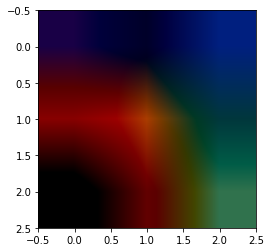

In [90]:
plt.imshow(f111, interpolation="bilinear", cmap="gray")

In [23]:
essai = sess.run(tf.reduce_mean(hidden_7_relu,[1, 2]),feed_dict={x:img, y: lbl, prob_1: 1.0, prob_2: 1.0, phase_train:False})
print(essai.shape)

(100, 192)


In [17]:
essai = sess.run(gap,feed_dict={x:img, y: lbl, prob_1: 1.0, prob_2: 1.0, phase_train:False})
print(essai.shape)

(100, 1, 1, 10)
